In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

This notebook introduces some basic concepts in tensorflow (TF) and presents the way that I think about my TF models.

Generally, my TF scripts take the following form:

    - Boilerplate (import and preprocess data, etc.)
    - Tensorflow Model (graph)
    - Developing loss functions/training algorithm
    - Training loop
    
The second and third item are where the most TF magic usually happens for me. Lets focus in on the second item the Tensorflow Model (graph).

A model (i.e. ‘computational graph’) is composed on three main parts:

    - Inputs (usually in the form of `placeholder` variables to be filled in later, we'll introduce this in a moment)
    - Tensorflow operations, which are composable functions which, and take `Tensor` objects as inputs and return `Tensor` objects as outputs.
    - Outputs of the model (i.e. network response, etc.). These are actually just more Tensor variables, outputs of operations, but there are usually a few distinguished ones you care about.

Before we get to coding, I just want to make one more point, which is to distinguish `Tensor` objects from `Variables`. When I am working with TF I generally think about two types of tensor object:

    - `Tensors`, which is a general term, but I usualy abuse language by using this to refer specifically to symbolic expressions: TF expressions whose value depends on a yet-to-be-specified input (for example, the output of a network depends on its inputs, which usually are not specified till run-time).
    - `Variables`, which specifically refers to tensor objects with a specific value. Generally these values are stored on the GPU, which is important because it is expensive to load data onto/off of the GPU. A good example of `Variable` objects are network weights. Their values are persistent, and can be used and updated entirely on the GPU, no need to offload them to do gradient updates, etc.
    
Ok. To try and make this distinction clear, lets look at an example. The following code defines an affine transformation (operation with a matrix, plus a vector offset) on a batch of inputs

In [2]:
batch_size = 10
vector_size = 100

input_vectors = tf.placeholder(tf.float32,shape = (batch_size,vector_size))

W = tf.Variable(np.float32(np.random.randn(vector_size,vector_size)))
t = tf.Variable(np.float32(np.random.randn(vector_size)))

output = tf.tensordot(input_vectors,W,axes = [[1],[1]]) + tf.expand_dims(t,0)

mean_out = tf.reduce_mean(output)

Instructions for updating:
Colocations handled automatically by placer.


Notice that `input_vectors` is a `placeholder`, this means that we can specify its value later on. On the other hand, W and t are `Variable` objects, and I have given the `Variable` function an explicit value (the output of a numpy RNG). This variable object will be stored on the GPU and has a determined value. 

But how do we actually compute the value of `mean_out`? If we just try to print it we get garbage:

In [3]:
print(mean_out)

Tensor("Mean:0", shape=(), dtype=float32)


This is just telling us that `output` is a `Tensor` object. Of course, `mean_out` __can't__ have a value yet, because it depends on `input_vectors`, which doesn't yet have a value!

In order to compute it we need to start a tensorflow `Session`, and tell tensorflow what `input_vectors` is. That looks like this:

In [4]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

data = np.random.randn(batch_size,vector_size)

out = sess.run(mean_out,{input_vectors:data})
print("The average output is: {}".format(out))
sess.close()

The average output is: 0.3387809991836548


The first three lines start a tensorflow `Session`. This is basically spinning up the GPU and getting tensorflow ready to compute stuff. We also create a `global_varialbes_initializer`. The reason for this is that the variables `W` and `t`, while they do have an explicit value, the actual numbers have not yet been plugged into the GPU memory (or something like that). the `global_variables_initializer`, prepares the variables for use by a tensorflow session. Try commenting out the first and third lines from this cell and see what happens!

The next line `data = ...` is just me generating an explicit value that we will feed for `input_vectors`.

The line `out = ...` is the powerhouse here. `sess.run` is the function that performs all the tensorflow computations. The first argument is what we want to compute (here `mean_out`) and the second argument is a `dict` that we can use to feed in values for undetermined tensors. The keys of the `dict` are the tensor objects that need to be specified, and the entries are the value to assign to them. (in the example above, we assign the placeholder `input_vectors` with the value `data`).

Lastly we close the session (we could leave it open and reuse it below, but I wanted to make each cell as independent as possible).

One more example shows that we can specify any tensor in the graph (not just the `input_vectors`).

In [5]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

data = np.random.randn(batch_size,vector_size)

out = sess.run(mean_out,{output:data})
print("The average output is: {}".format(out))
sess.close()

The average output is: 0.013364719226956367


This cell is identical to the last, but we specify the `output` tensor instead of `input_vectors`. Sicne we specify the `output` we no longer need `input_vectors` to compute `mean_out` because once `output` is specified, we can unambiguously determine `mean_out`. 

As one more example, we can specify `W` explicitly if we want.

In [6]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

data = np.random.randn(batch_size,vector_size)
Wtemp1 = np.random.randn(vector_size,vector_size)
Wtemp2 = np.random.randn(vector_size,vector_size)

out = sess.run(mean_out,{input_vectors:data,W:Wtemp1})
print("The average output is: {}".format(out))

out = sess.run(mean_out,{input_vectors:data,W:Wtemp2})
print("The average output is: {}".format(out))

out = sess.run(mean_out,{input_vectors:data})
print("The average output is: {}".format(out))

sess.close()

The average output is: -0.3291844427585602
The average output is: -0.6489627957344055
The average output is: 0.3882110118865967


As you can see in this cell, we specify W to be two different values, and then in the third `sess.run` we leave it unspecified, and it defaults back to the value we initialized it to above. Cool!

So, what you've seen here is a simple example of an input which is acted upon by some variables stored on the GPU, and produces an output. There were four examples of operations given here: the `tensordot` that applies `W` to the input, the `tf.expand_dims` which reshaped `t`, the addition of the two terms to produce `output`, and the `tf.reduce_mean` operation which took the average output. These operations produce tensors as ouput, and computing them with `sess.run` performs that operation. In all the examples above, the operations take symbolic expressions and produce more symbolic expressions, but operations can also do other things, such as change the value of `Variable` objects. 

As an example of this, lets make an operation which shifts `W` by a specified ammount.

In [7]:
change_W = tf.assign(W,W+.01)

the expression `change_W` represents `W` *after* it has been shifted. to actually apply the shift we have to `sess.run` the tensor `change_W`.

In [8]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

w = sess.run(W)
print("shift 0: {}".format(w.mean()))

for k in range(5):
    _ = sess.run(change_W)
    w = sess.run(W)
    print("shift {}: {}".format(k+1,w.mean()))
sess.close()

shift 0: 0.008368621580302715
shift 1: 0.018368614837527275
shift 2: 0.02836860716342926
shift 3: 0.03836860507726669
shift 4: 0.04836859181523323
shift 5: 0.05836858972907066


So, now we've changed the value of `W`. Cool! The thing that confuses me about this sometimes is that the tensor `change_W` contains the instructions to applly the shift. For a long time I thought of the tensor objects as merely representing not-yet-determined values of mathematical expressions, but they are more than that. They contain a set of instructions which can include manipulating variables, combining tensors, and more. 

As a small application, lets use the `tf.assign` function, and gradients, to solve a linear set of equations using gradient descent. 

In [9]:
lr = .001

target_vectors = tf.placeholder(tf.float32,(batch_size,vector_size))
error = tf.reduce_mean((target_vectors - output)**2)
grad = tf.gradients(error,W)
grad_step = tf.assign(W, W - lr * grad[0])

data = np.random.randn(batch_size,vector_size)
target = np.random.randn(batch_size,vector_size)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

err = sess.run(error,{input_vectors:data,target_vectors:target})

print(err)

for k in range(5000):
    w = sess.run(grad_step,{input_vectors:data,target_vectors:target})
    if k%500 == 0:
        err = sess.run(error,{input_vectors:data,target_vectors:target})
        print("Step {} error: {}".format(k,err))
        
sess.close()

100.57993
Step 0 error: 100.53903198242188
Step 500 error: 82.19416809082031
Step 1000 error: 67.4444351196289
Step 1500 error: 55.54258728027344
Step 2000 error: 45.904117584228516
Step 2500 error: 38.070491790771484
Step 3000 error: 31.680931091308594
Step 3500 error: 26.450759887695312
Step 4000 error: 22.154603958129883
Step 4500 error: 18.61350440979004


It works! Or at least the error goes down, great. But so slowly!?

What you saw here was defining an error (RMS error between the `output` and a new placeholder`target_vectors`), then computation of the gradient of the error w.r.t. `W`, and then the creation of an operator which takes a single gradient descent step. Then there is the boilerplate of starting a session, and then a "training loop" that perform gradient descent.

Ok, the last thing I want to show you is tensorflows built in tools for optimization, which will work much better than this lame gradient descent. In the previous cell I defined by own gradient descent operation using the `gradients` function. Tensorflow, however, has many algorithms pre-made in the `train` module. We can perform the same optimization using the `Adam` algorithm in the following way:

In [10]:
lr = .001

target_vectors = tf.placeholder(tf.float32,(batch_size,vector_size))
error = tf.reduce_mean((target_vectors - output)**2)

adam = tf.train.AdamOptimizer(learning_rate = lr)
grad_step = adam.minimize(error)

data = np.random.randn(batch_size,vector_size)
target = np.random.randn(batch_size,vector_size)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

err = sess.run(error,{input_vectors:data,target_vectors:target})

print(err)

for k in range(5000):
    w = sess.run(grad_step,{input_vectors:data,target_vectors:target})
    if k%500 == 0:
        err = sess.run(error,{input_vectors:data,target_vectors:target})
        print("Step {} error: {}".format(k,err))
        
sess.close()

101.22353
Step 0 error: 100.70338439941406
Step 500 error: 4.3044939041137695
Step 1000 error: 0.05761091783642769
Step 1500 error: 0.00020962732378393412
Step 2000 error: 1.6323159002240573e-07
Step 2500 error: 1.3312760616113195e-10
Step 3000 error: 2.290734095466984e-11
Step 3500 error: 8.269807581784416e-12
Step 4000 error: 3.3103294411196416e-11
Step 4500 error: 4.210535566040452e-12


As you see, adam converged much faster. Although I have trouble taking this advice sometimes: it is usually better to find someone else's implementation than to create your own :P

Great! I hope you have some ideas now of how to do stuff in TF. Check out the other notebooks for full-fledged examples of networks that learn to recognize MNIST digits. 

Some stuff for you to try here is:

    - Change the error function and see how it effects learning (for example, what about using `tf.reduce_max` instead of `tf.reduce_mean`?)
    - Modify the code so that it perform linear regression on the batch, instaed of just solving a linear regression problem, by specifying the "true" transofrmation and noise, generating batches of data, and fitting `W` and `t`.

## The infamous XOR problem

In this section we are going to create a simple network to solve the xor problem and train it, and we will play along the way with pitfalls we might fall into.

First we prepare the data, we are just going to give the four noiseless data points to make life easy.

In [2]:
raw_data = np.float32([[a,b] for a in [0,1] for b in [0,1]])
raw_output = np.float32([[bool(a)^bool(b)] for a,b in raw_data])

In [3]:
raw_data

array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32)

In [4]:
raw_output

array([[0.],
       [1.],
       [1.],
       [0.]], dtype=float32)

Now that we have the data all set up, lets build the network. The next cell allows you to set the number of layers, number of hidden nodes in each layer, the learning rate and the activation of the hidden layers.

We'll go through it as a group, but try running it with the default parameters.

In [32]:
nlayers = 2
nhidden = 2
learning_rate = .01

#activation = tf.nn.sigmoid
activation = tf.nn.tanh

inp = tf.placeholder(tf.float32,shape = [None,2])
out = tf.placeholder(tf.float32,shape = [None,1])

net = inp

for k in range(nlayers-1):
        net = tf.layers.dense(net,nhidden,activation = activation)
        
net = tf.layers.dense(net,1,activation = tf.nn.sigmoid)

loss = tf.reduce_mean((net - out)**2)

OPT = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
#OPT = tf.train.AdamOptimizer(learning_rate = learning_rate)

train = OPT.minimize(loss)

In [42]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

The training loop is in the next cell. You can specify how many steps to train for (`nepc`) and now often to report. It defaults to report ten times throughout training.

In [43]:
nepc = 20000
report = nepc // 10
loss_list = []
for k in range(nepc):
    _,current_loss = sess.run([train,loss],{inp:raw_data,out:raw_output})
    loss_list.append(current_loss)
    if k%report == 0:
        print("{}\tloss:{}".format(k,current_loss))
        
x = np.linspace(0,1,20)
feature_map = sess.run(net,{inp:[[a,b] for a in x for b in x]})
feature_map = np.squeeze(np.reshape(feature_map,[len(x),len(x),1]))

print("Done! Final loss: {}".format(current_loss))

0	loss:0.2564850449562073
2000	loss:0.22908960282802582
4000	loss:0.18955940008163452
6000	loss:0.12354189902544022
8000	loss:0.06754899770021439
10000	loss:0.03948486968874931
12000	loss:0.025964925065636635
14000	loss:0.018689492717385292
16000	loss:0.014331819489598274
18000	loss:0.01149551197886467
Done! Final loss: 0.009530280716717243


In [44]:
sess.close()

Now we visualize the loss throughout training and the reponse of the network to different inputs.

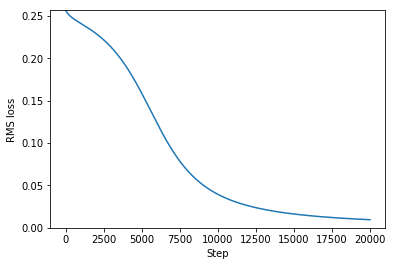

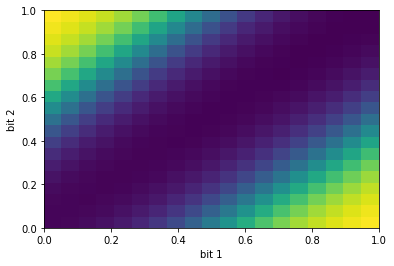

In [45]:
plt.plot(loss_list)
plt.xlabel("Step")
plt.ylabel("RMS loss")
plt.ylim([0,np.max(loss_list)])
plt.show()

plt.pcolor(x,x,feature_map)
plt.xlabel("bit 1")
plt.ylabel("bit 2")
plt.show()

Great! You should try running this a few times with different paramters.

For the remainder of the class, work with people around you to do the following:
  * Try changing the nubmer of layers and hidden neurons, how does this change the speed at which the network converges?
  * Change the inputs to include multiple samples from each group with some noise.
  * Change the inputs to fill the entire region in the corresponding corner of the [0,1,0,1] square. i.e. instead provide data so the network learns to compute xor(sign(a - .5),sign(b - .5)). How does this change the ability of the netowrk to converge? Why?
  * For the remainder of the time, just play around: can you generate a new set of tensorflow code to compute something for you? Come up with a function/series of computations you want to perform and generate code to do it for you in tensorflow. Remember that the online TF documentation will get you a long way if you don't know how to do something!